# Recurrent Neural Networks (RNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
import platform
print('Using python: ', platform.python_version())
print('Using torch version: ', torch.__version__)
print('Using device: ', device)

Using python:  3.8.6
Using torch version:  1.7.0
Using device:  cpu


## 1. Simple Recurrent Neural Network

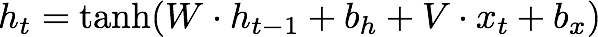

In [3]:
import torch.nn as nn
from sentiment_analysis.rnn.rnn_nn import RNN

Output shape test passed :), torch.Size([10, 1, 3]) == torch.Size([10, 1, 3])
Hidden shape test passed :), torch.Size([1, 1, 3]) == torch.Size([1, 1, 3])

Difference between pytorch and your RNN implementation for 'h_seq': 0.00
Cool, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'h': 0.00
Cool, you implemented a correct model.


True

### 2.1. Vanishing Gradient

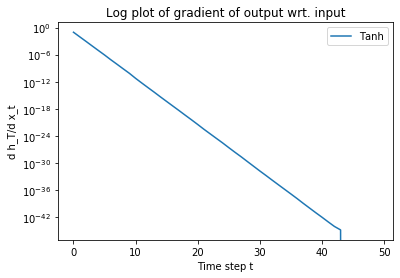

In [5]:
hidden_size=1
input_size= 1

time_steps=50
rnn = RNN(input_size, hidden_size, 'tanh')

for p in rnn.parameters():
    p.data.fill_(0.1)

x = torch.randn(time_steps, 1, input_size)
x.requires_grad=True
_, h = rnn(x)
h.requires_grad
h.sum().backward()
grad_tanh=x.grad.view(-1)

plt.semilogy(np.flip(abs(grad_tanh.detach().cpu().numpy())), label="Tanh")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show()

## 3. Long-Short Term Memory Network (LSTM)

<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png width="600">


<img src=https://miro.medium.com/max/1400/1*-kBdBYzR7lpimgb3AIRkOw.png width="400">


The operations inside the LSTM are given as

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1  width="400" align="left">

In [6]:
from sentiment_analysis.rnn.rnn_nn import LSTM

# choose your input parameters
input_size=3
hidden_dim=3
seq_len= 10

# define the two models
pytorch_lstm = nn.LSTM(input_size, hidden_dim)
own_lstm = LSTM(input_size, hidden_dim)

x = torch.randn(seq_len, 1, input_size)

Output shape test passed :), torch.Size([10, 1, 3]) == torch.Size([10, 1, 3])
Hidden shape test passed :), torch.Size([1, 1, 3]) == torch.Size([1, 1, 3])

Difference between pytorch and your RNN implementation for 'h_seq': 0.00
Cool, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'h': 0.00
Cool, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'c': 0.00
Cool, you implemented a correct model.


True

### 3.1 Explore Gradients

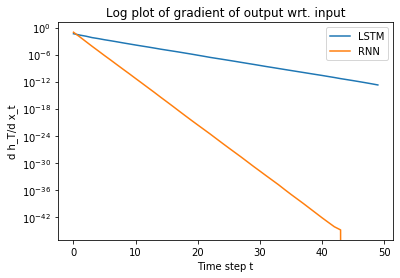

In [9]:
hidden_size = 1
input_size = 1

time_steps=50
rnn = RNN(input_size, hidden_size)
for p in rnn.parameters():
    p.data.fill_(0.1)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad = True
_,h = rnn(X)
h.requires_grad
h.sum().backward()
grad_rnn = X.grad.view(-1)

lstm = LSTM(input_size, hidden_size)
for p in lstm.parameters():
    p.data.fill_(0.1)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad=True
_,(h, c) = lstm(X)
h.sum().backward()
grad_lstm = X.grad.view(-1)

plt.semilogy(np.flip(abs(grad_lstm.detach().cpu().numpy())) , label="LSTM")
plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="RNN")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show()


## 4. Exploding Gradients Problem

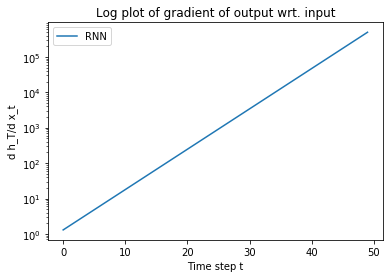

In [10]:
hidden_size = 1
input_size = 1

time_steps=50
rnn = RNN(input_size, hidden_size, activation='relu')
for p in rnn.parameters():
    p.data.fill_(1.3)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad = True
_,h = rnn(X)
h.requires_grad
h.sum().backward()
grad_rnn = X.grad.view(-1)  # next(rnn.parameters()).grad.view(-1)

plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="RNN")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show()

One possible solution of this problem is gradient clipping. Gradient clipping shrinks gradient magnitude. We can use [clip_grad_norm_](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) function from PyTorch here. Observe the gradient magnitude is smaller.

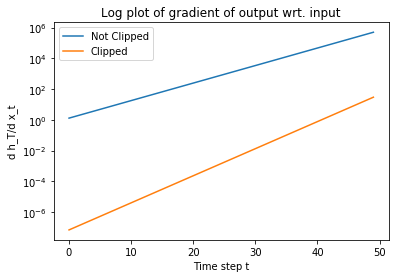

In [11]:
from torch.nn.utils import clip_grad_norm_

grad_rnn_unclipped = grad_rnn.clone()

hidden_size = 1
input_size = 1
gclip = 40

time_steps=50
rnn = RNN(input_size, hidden_size, activation='relu')
for p in rnn.parameters():
    p.data.fill_(1.5)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad = True
_,h = rnn(X)
h.requires_grad
h.sum().backward()
clip_grad_norm_(X, gclip)
grad_rnn = X.grad.view(-1)  # next(rnn.parameters()).grad.view(-1)

plt.semilogy(np.flip(abs(grad_rnn_unclipped.detach().cpu().numpy())), label="Not Clipped")
plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="Clipped")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show()

## 5. Handling Batches with Different Sequence Lenghts

In [12]:
from torch.nn.utils.rnn import (
    pack_padded_sequence,
    pad_packed_sequence
)

In [13]:
padded_seq = torch.arange(0, 12).view(3, 2, 2).float()
lengths = torch.tensor([3, 2]).long()

padded_seq, lengths

(tensor([[[ 0.,  1.],
          [ 2.,  3.]],
 
         [[ 4.,  5.],
          [ 6.,  7.]],
 
         [[ 8.,  9.],
          [10., 11.]]]), tensor([3, 2]))

In [15]:
padded_seq[2, 1, :]

tensor([10., 11.])

In [16]:
lengths

tensor([3, 2])

In [20]:
padded_seq.shape

torch.Size([3, 2, 2])

In [21]:
lengths.shape

torch.Size([2])

PyTorch RNNs internally use the [PackedSequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.PackedSequence.html) to store and process batches with varying length sequences:

In [17]:
packed_seq = pack_padded_sequence(padded_seq, lengths)
packed_seq

PackedSequence(data=tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.],
        [8., 9.]]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

In [22]:
pad_packed_sequence(packed_seq)

(tensor([[[0., 1.],
          [2., 3.]],
 
         [[4., 5.],
          [6., 7.]],
 
         [[8., 9.],
          [0., 0.]]]), tensor([3, 2]))

In [25]:
seq = torch.tensor([[1,2,0], [3,0,0], [4,5,6]])
seq

tensor([[1, 2, 0],
        [3, 0, 0],
        [4, 5, 6]])

In [29]:
lens = [2, 1, 3]
lens

[2, 1, 3]

In [31]:
packed = pack_padded_sequence(seq, lens, batch_first=True, enforce_sorted=False)
packed

PackedSequence(data=tensor([4, 1, 3, 5, 2, 6]), batch_sizes=tensor([3, 2, 1]), sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))

In [32]:
seq_unpacked, lens_unpacked = pad_packed_sequence(packed, batch_first=True)

In [33]:
seq_unpacked

tensor([[1, 2, 0],
        [3, 0, 0],
        [4, 5, 6]])

In [34]:
lens_unpacked

tensor([2, 1, 3])